In [1]:
%reset
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.precision', 3)

# Opdracht 1: Exploratieve Data Analyse:
Gemaakt door de Majestueuze data-jokers:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>

In [2]:
class EDA:
    def __init__(self, cols):
        # Define feature and target columns
        self.feature_cols = cols.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        # Define which columns need to have zero values removed and which columns to replace the values with a KNN model
        self.zero_value_cols = ['BMI', 'BloodPressure', 'Glucose']
        self.col_to_replace = ["Insulin", "SkinThickness"]
        
        # Define objects to use
        self.df_handler = DfHandler()
        self.vis = Visualizer()
        
    def analyze_data(self, df):
        # Display the first 5 rows of the dataset to get a feel for how it looks
        display(df.head(5))
        
        # Display several stats of the dataset
        self.df_handler.display_stats(df, self.feature_cols)
        
        # Display plots to show how the data is distributed in the feature columns
        self.vis.box_dist_plots(df, self.feature_cols)
        
        # Display the correlation between the feature columns and the target column
        self.vis.corr_heatmap(self.df_handler.get_corr(df, self.feature_cols, self.target_col))
    
    def clean_data(self, df, standardise=False, neighbors=5):
        # Remove zero values from the previously defined columns
        df = self.df_handler.clean_zero_values(df, self.zero_value_cols, self.col_to_replace)
        
        # Either standardise and replace values with KNNImputer generated values 
        # or just replace values with KNNImputer values
        if standardise:
            df = self.df_handler.standardise_df(df, self.feature_cols)
            df = self.df_handler.replaceWithKNN(df, self.col_to_replace, neighbors=neighbors)
            return df
        else:
            df = self.df_handler.replaceWithKNN(df, self.col_to_replace, neighbors=neighbors)
            return df
        
        

In [3]:
class Visualizer:
    def box_dist_plots(self, df, cols):
        # Create a useable figure with subplots
        fig, axes = plt.subplots(len(cols), 2, figsize=(10, 15))
        fig.tight_layout()   
        
        # Create boxplots and histograms for every feature column defined
        for index, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[index, 0])    
            sns.histplot(x=df[col], ax=axes[index, 1])
            
    def corr_heatmap(self, corr_df):
        # Create a 1D heatmap of the correlation between feature columns and the target column 
        fig = plt.figure(figsize=(5, 5))
        sns.heatmap(corr_df, annot=True)
        
    

In [4]:
class DfHandler:
    def display_stats(self, df, cols):
        # Display the count, mean, std, min, 25%, 50%, 75%, max and dtype of the given dataframe and columns
        stats = df[cols].describe().T
        stats['dtype'] = [df[col].dtype for col in cols]
        display(stats)
        
    def clean_zero_values(self, df, cols, nan_cols=[], no_message=False):
        # Replace 
        for col in cols:
            if not no_message:
                print(f"Removing {len(df[df[col] == 0])} zero values from {col} in the DataFrame...")
            df = df.drop(df.loc[(df[col] == 0)].index)
        if not no_message:
            for col in nan_cols:
                print(f"replacing zero values in {col} with np.NaN value...")
        if nan_cols:
            df[nan_cols] = df[nan_cols].replace(0, np.NaN)    
        return df
        
    
    def get_corr(self, df, feature_cols, target_col):
        corr = pd.DataFrame(df[feature_cols].corrwith(df[target_col], method='pearson'))
        corr = corr.sort_values(0, ascending=False)
        return corr
            
    def standardise_df(self, df, cols):
        print(f"Standardising dataset...")
        scaler = StandardScaler()
        df[cols] = pd.DataFrame(scaler.fit_transform(df[cols]),
                                                     index=df[cols].index,
                                                     columns=df[cols].columns)
        return df
    
    def testKNN(self, df, feature_cols, target_col, frac, iterations, neighbors, visualization=True):
        # Remove all the zero values of the dataframe
        df = self.clean_zero_values(df, feature_cols, no_message=True)
        
        # Set up empty arrays to store the RMS Errors in
        rmse_errors = np.array([])
        mean_rmse_errors = np.array([])
        
        # Display what is happening
        display(f'Testing KNNImputer with {iterations} samples of {frac*100}% of the dataset for the neighbors provided')
        display(f'Doing a total of {iterations} * {len(neighbors)} = {iterations*len(neighbors)} tests on the KNNImputer.')
        
        # Run the test on all the possible iterations and different neighbors
        for neighbor in neighbors:
            for i in range(iterations):
                # Sample a random 20% of the dataset to replace with KNNImputer data 
                sample_index = df.sample(frac=frac).index
                
                # Save the true values for calculating the RSME later
                true_values = df.loc[sample_index, target_col]
                
                # Replace the true values with np.NaN and then replace np.NaN with KNNImputer data
                df.loc[sample_index, target_col] = np.NaN
                df = self.replaceWithKNN(df, [target_col], neighbors=neighbor, no_message=True)
                
                # Save the predicted values for calculating the RSME later
                predicted_values = df.loc[sample_index, target_col]
                
                # Calculate the RMSE with the true and predicted values
                error = mean_squared_error(true_values, predicted_values, squared=False)
                
                # Collect all the RMS Errors and calculate the average of all the iterations per neighbor and save that
                rmse_errors = np.append(rmse_errors, error)
            mean_rmse_errors = np.append(mean_rmse_errors, rmse_errors.mean())
            rsme_errors = np.array([])
        error_df = pd.DataFrame({'n_neighbors': neighbors, 'Mean_RSME': mean_rmse_errors})
        
        # Plot a lineplot with the change in average RMSE per neighbor
        if visualization:
            sns.lineplot(x=error_df['n_neighbors'], y=error_df['Mean_RSME'])
            
        # Return a dataframe with the neighbors and the average RMSE
        return error_df
        
    def replaceWithKNN(self, df, cols, neighbors=5, no_message=False):
        # Display a message about what is happening if no_message is False
        if not no_message:
            for col in cols:
                print(f"Replacing np.NaN {col} values with KNNImputer values...")
        
        # Use KNNImputer to replace np.NaN values in the dataset
        knnImputer = KNNImputer(weights='distance', n_neighbors=neighbors)
        df = pd.DataFrame(knnImputer.fit_transform(df), index=df.index, columns=df.columns)
        
        # Return the new dataset
        return df

In [5]:
df = pd.read_csv("train_c.csv")
eda = EDA(df.columns)

## Data bekijken
De eerste stap die wij volgen is het bekijken van de verdelingen van de data, dit doen we door de basisstatistieken van alle feature kolommen te bekijken. 
we bekijken volgende statistieken:
- Gemiddelde
- Mediaan
- Standaard deviatie
- Min- en Maximum
- Eerste en derde kwartiel


Ook plotten wij van elke feature kolom de boxplot en een histogram om te kijken hoe de waardes verdeeld zijn in de dataset. Hiermee kunnen wij zien of er data in de dataset zit die wellicht niet juist is of dat er wellicht een hoop uitschieters zijn. 
Ook kunnen we zien of de data normaal verdeeld is of niet en of er eigenaardigheden zijn.

Als laatst gaan wij ook alvast kijken welke correlaties er zijn tussen de feature kolommen en de target kolom, hiermee kunnen we alvast een beeld schetsen over hoe de feature kolommen de target kolom kunnen beschrijven.

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668,6,98,58,33,190,34.0,0.430,43,0
1,324,2,112,75,32,0,35.7,0.148,21,0
2,624,2,108,64,0,0,30.8,0.158,21,0
3,690,8,107,80,0,0,24.6,0.856,34,0
4,473,7,136,90,0,0,29.9,0.210,50,0


,count,mean,std,min,25%,50%,75%,max,dtype
Age,614.0,33.265,11.851,21.000,24.000,29.000,41.000,72.00,int64
BMI,614.0,31.930,8.137,0.000,27.400,32.150,36.500,67.10,float64
BloodPressure,614.0,68.904,19.933,0.000,62.000,72.000,80.000,114.00,int64
DiabetesPedigreeFunction,614.0,0.468,0.329,0.078,0.238,0.365,0.629,2.42,float64
Glucose,614.0,120.466,31.960,0.000,99.000,115.000,140.000,197.00,int64
Insulin,614.0,81.251,116.947,0.000,0.000,27.000,130.000,744.00,int64
Pregnancies,614.0,3.809,3.376,0.000,1.000,3.000,6.000,15.00,int64
SkinThickness,614.0,20.456,16.063,0.000,0.000,23.000,32.000,99.00,int64


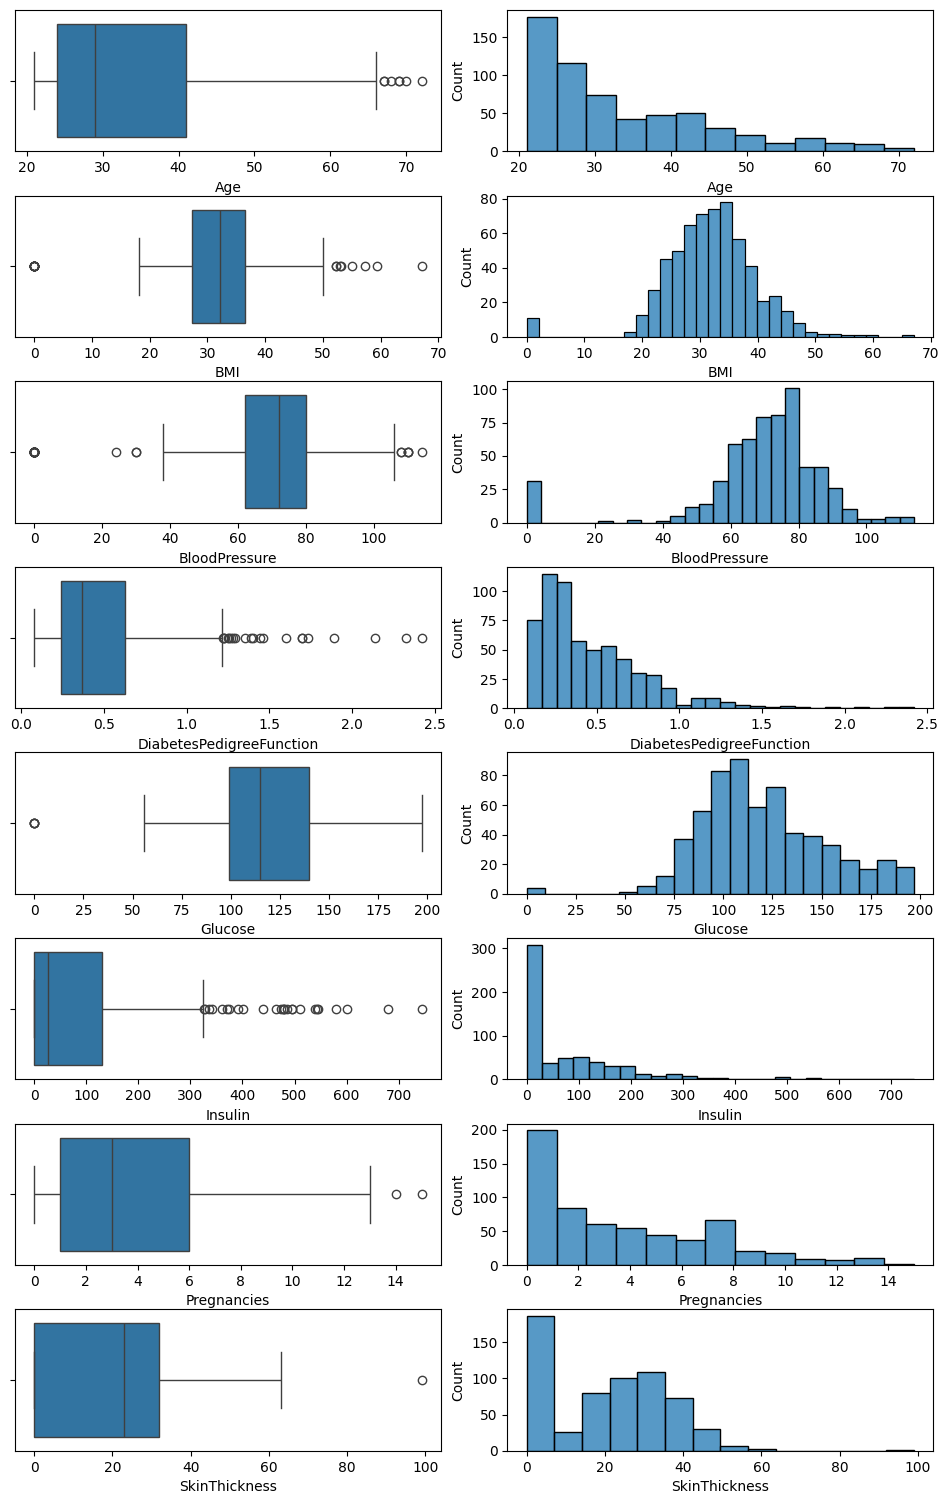

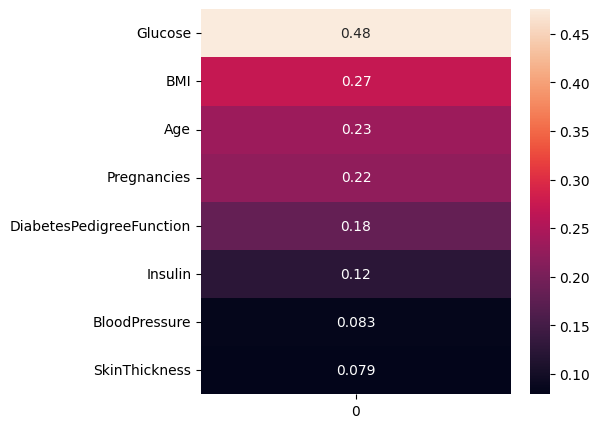

In [6]:
eda.analyze_data(df)

## Voldoet de data aan de voorwaarden voor machine learning?
De data voldoet aan de voorwaarden aangezien de data:
- In een dataframe staat
- Geen lege waardes bevat
- In numerieke waardes is beschreven

## Data opschonen
Echter vinden wij dat de data nog schoongemaakt kan worden, dit vinden wij omdat in de boxplots te zien valt dat de volgende kolommen nog waardes van 0 bevatten die niet mogelijk zouden moeten zijn.
- Glucose
- BMI
- BloodPressure
- Insulin
- SkinThickness

Deze waardes met 0 gaan wij uit de data verwijderen.

Ook zien we dat er veel uitschieters zijn, wij vinden het belangrijk om deze data alsnog mee te nemen aangezien wij denken dat dit wellicht komt door omstandigheden die ook kunnen bijdragen aan diabetes.

'Testing KNNImputer with 25 samples of 20.0% of the dataset for the neighbors provided'

'Doing a total of 25 * 25 = 625 tests on the KNNImputer.'

,n_neighbors,Mean_RSME
0,1,58.636
1,2,45.925
2,3,35.152
3,4,28.183
4,5,23.757
5,6,20.386
6,7,17.789
7,8,15.752
8,9,14.128
9,10,12.795


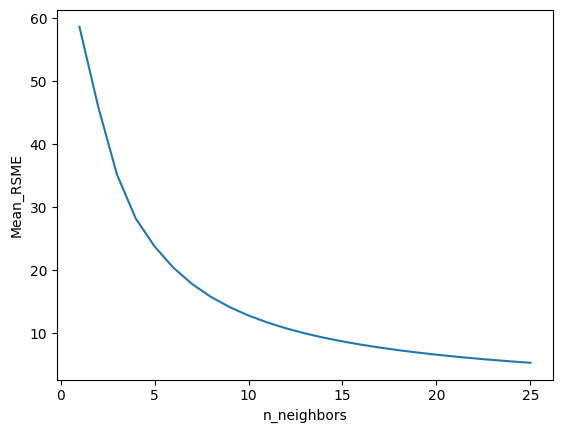

In [7]:
handler = DfHandler()
handler.testKNN(df, df.columns.difference(['p_id', 'Outcome']), 'Insulin', 0.2, 25, range(1, 26))

Removing 11 zero values from BMI in the DataFrame...
Removing 24 zero values from BloodPressure in the DataFrame...
Removing 4 zero values from Glucose in the DataFrame...
replacing zero values in Insulin with np.NaN value...
replacing zero values in SkinThickness with np.NaN value...
Standardising dataset...
Replacing np.NaN Insulin values with KNNImputer values...
Replacing np.NaN SkinThickness values with KNNImputer values...


,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668.0,0.649,-0.768,-1.182,0.350,0.254,0.209,-0.124,0.814,0.0
1,324.0,-0.541,-0.312,0.198,0.256,-0.305,0.454,-0.980,-1.048,0.0
2,624.0,-0.541,-0.442,-0.695,0.117,-0.464,-0.253,-0.950,-1.048,0.0
3,690.0,1.244,-0.475,0.605,-0.037,0.210,-1.148,1.169,0.052,0.0
4,473.0,0.947,0.469,1.417,0.191,-0.245,-0.383,-0.792,1.406,0.0


,count,mean,std,min,25%,50%,75%,max,dtype
Age,575.0,2.719e-16,1.001,-1.048,-0.794,-0.371,0.645,3.098,float64
BMI,575.0,-3.290e-16,1.001,-2.071,-0.715,-0.022,0.584,4.986,float64
BloodPressure,575.0,2.719e-16,1.001,-3.944,-0.695,-0.045,0.605,3.366,float64
DiabetesPedigreeFunction,575.0,1.406e-16,1.001,-1.193,-0.704,-0.303,0.500,5.917,float64
Glucose,575.0,1.452e-16,1.001,-2.135,-0.703,-0.182,0.665,2.455,float64
Insulin,575.0,-4.597e-04,0.782,-1.214,-0.457,-0.139,0.249,4.873,float64
Pregnancies,575.0,6.488e-17,1.001,-1.137,-0.839,-0.244,0.649,3.328,float64
SkinThickness,575.0,-4.980e-03,0.876,-2.091,-0.528,-0.003,0.444,6.545,float64


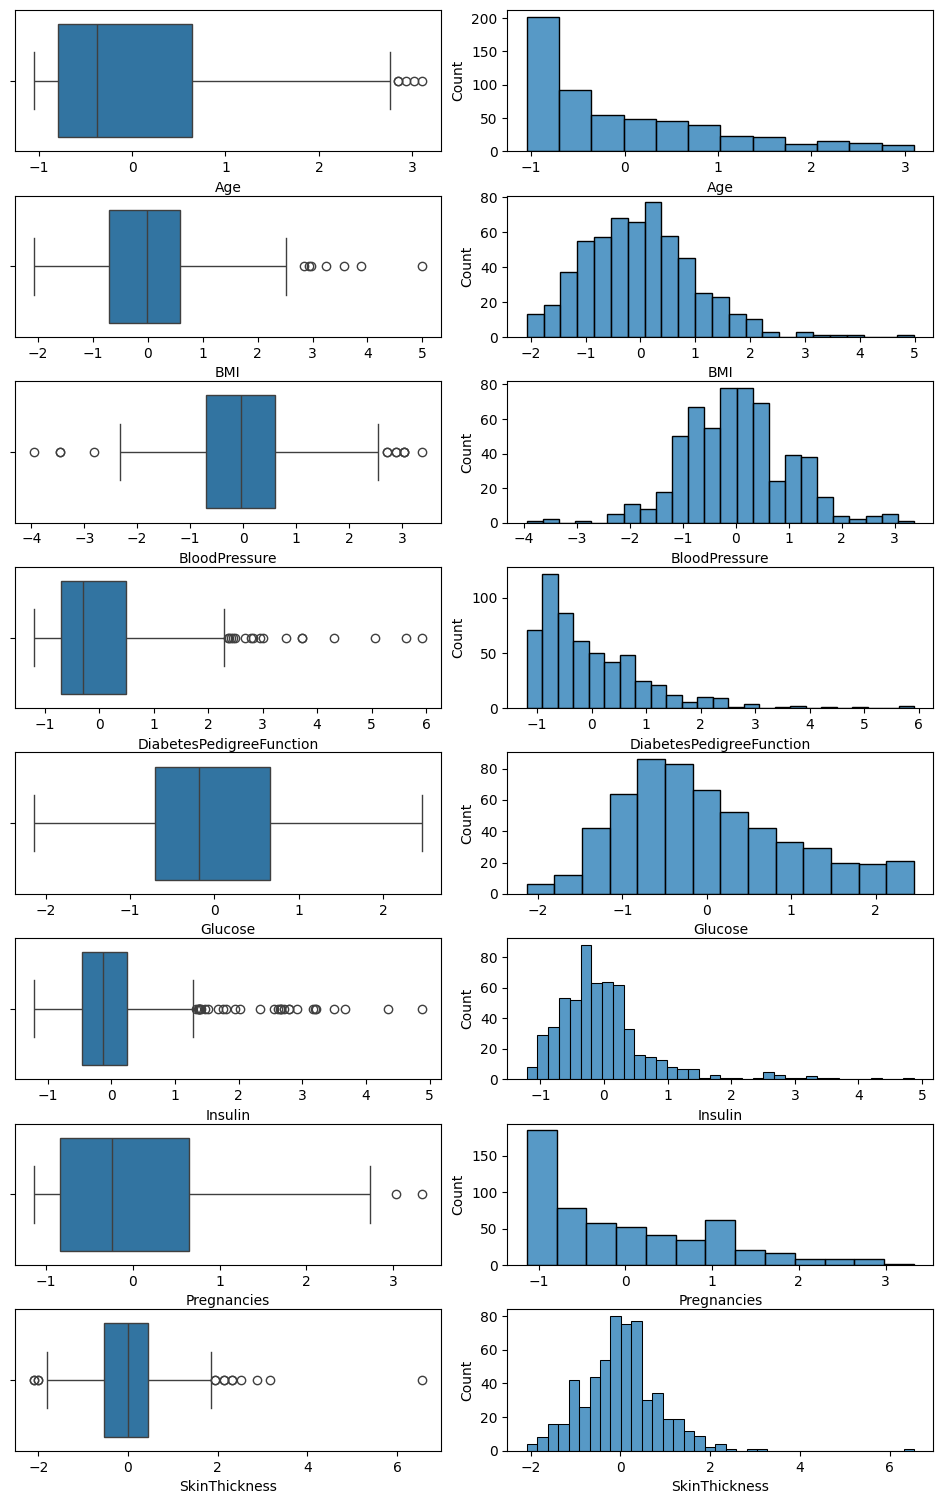

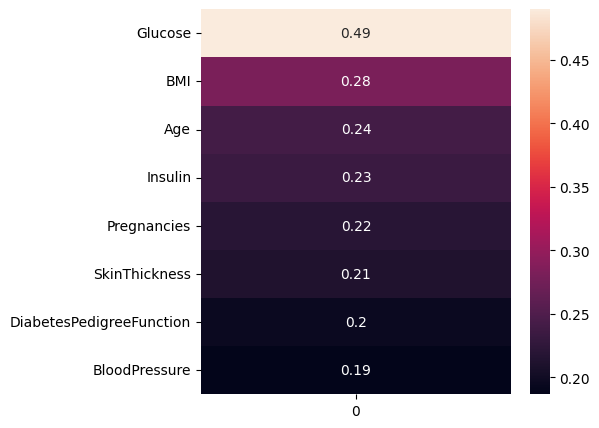

In [8]:
cleaned_df = eda.clean_data(df, standardise=True, neighbors=10)
eda.analyze_data(cleaned_df)

## Opvallende dingen over opgeschoonde data
We zien dat de data van 614 rijen naar 312 rijen is gegaan, dit betekent dat wij een hoop rijen hebben verwijderd. Echter vinden wij dat dit beter is dan het alternatief, aangezien wij geen vertrouwen hebben goede modellen te kunnen maken als we geen goede data invoeren in de modellen. Zoals het beroemde gezegde "Garbage in = garbage out". 

We zien ook dat de correlaties omhoog zijn gegaan en dit is een goede indicatie dat de data die nu verwijderd is geen goede weergave gaf van de realiteit.

## Standaardiseren
Het staandaardiseren van data houdt in dat je de data schaalt op een manier dat het gemiddelde 0 wordt en de standaard deviatie 1. Om dit te doen wordt het aangeraden om data te hebben wat in een bell-curve valt en dat niet teveel outliers heeft. Ook is het alleen nuttig als feature kolommen ver uit elkaar liggen qua grootte van de waardes. Dit wordt gedaan om verschillende machine learning modellen beter te kunnen trainen als deze kijken naar afstand tussen datapunten om beslissingen te maken (zoals KNN of SVM).

Hoewel wij wel grote waardeverschillen hebben tussen de feature en KNN gebruiken om missende waardes in te vullen hebben wij toch besloten om niet de data te standaardiseren

# Evaluatie

### Deze opdracht heeft betrekking op een bepaalde vorm van machine learning. Welke vorm is dit? Licht het antwoord toe.


Tijdens de opdracht maken wij gebruik van de datasets genaamd "train_c.csv" en "test_c.csv".
Vanuit de opdracht omschrijving is te achterhalen dat we bij "train_c.csv" met een gelabelde dataset te maken hebben. De kolom "Outcome" is meegegeven en dit is in onze modellen dan ook de target kolom. Verder zijn alle overige kolommen ook gelabeld, dit zijn de feuture kolommen.
Ook wordt er gesproken over onze dataset "test_c.csv". Dit is de niet gelabelde dataset waarvoor wij uiteindelijk voorspellingen gaan maken aan de hand van onze modellen. 
https://brightspace.hhs.nl/d2l/le/lessons/56591/topics/663651

Door deze observaties kunnen wij ervan uit gaan dat wij te maken hebben met supervised machine learning. Hierbij worden modellen getraind met behulp van gelabelde datasets. Dit is data waar van te voren de juiste target uitkomst aan is gekoppeld. Met deze data gaat het model voorspellingen doen op niet gelabelde data.
https://www.breinstein.nl/de-digitale-wereld/een-introductie-in-machine-learning/
https://www.ibm.com/topics/supervised-learning





### Geef aan met welke “metrics”, voor deze vorm van machine learning, bepaalt kan worden hoe goed een model presteert. Toon de uitkomsten op deze metrics aan de hand van een zelf te kiezen machine learning algoritme.



Binnen supervised learning zijn er twee verschillende takken, zo is er regressie en classificatie. Bij regressie wordt aan de hand input data een waarde voorspelt. Bij classificatie wordt er voorspelt welk class label bij de input data hoort.
https://datasciencepartners.nl/supervised-learning/

In het geval van diabetes voorspellen is de waarde True of False. Dit geeft aan of iemand wel of niet diabetes heeft. Hier is er sprake van classificatie. Tijdens de opdracht zal er gewerkt worden met classificatie modellen.

Er zijn verschillende manieren om de prestaties van een classificatie model te presenteren, die manieren worden metrics genoemd. Voor classificatie gebruiken wij de volgende metrics:

Accuracy

Precision

Recall

F1-score

De uitkomsten van de bovenstaande metrics worden onder deze markdown cel getoond. Er is gebruik gemaakt van LogisticRegression voor de voorspellingen en een confusion matrix display om de uitkomsten te tonen.

In [15]:
print(class_report)

              precision    recall  f1-score   support

     class 0       0.78      0.87      0.82       116
     class 1       0.73      0.58      0.65        69

    accuracy                           0.76       185
   macro avg       0.75      0.73      0.73       185
weighted avg       0.76      0.76      0.76       185



### Leg uit hoe iedere metric wordt berekend. Gebruik hierbij een confusion matrix.



Voor het berekenen van de metrics gebruiken wij de bijbehorende formules. In de formules worden de volgende eenheden gebruikt.

True Positive(TP): De input data wordt correct gelabeld als True.

True negative(TN): De input data wordt correct gelabeld als False.

False Positive(FP): De input data wordt incorrect gelabeld als True.                           Hierbij is de input data werkelijk False.

False Negative(FN): De input data wordt incorrect gelabeld als False.                           Hierbij is de input data werkelijk True.

Deze eenheden komen ook terug in de confusion matrix

![1 jMs1RmSwnYgR9CsBw-z1dw.png](<attachment:1 jMs1RmSwnYgR9CsBw-z1dw.png>)

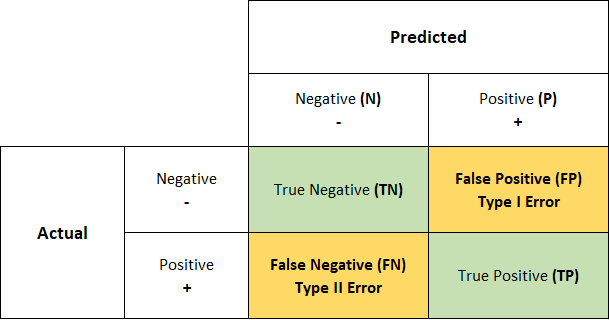


Nu de eenheden duidelijk zijn zullen de verschillende metrics en hun formules hieronder worden toegelicht.

## Accuracy:
Bij accuracy wordt er gemeten hoe vaak het classificatie model een correcte voorspelling heeft gemaakt. Hierbij wordt de som van het aantal correcte voorspellingen gedeeld door de som van het totaal aantal voorspellingen.

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

## Precision:
Bij precison wordt er gemeten hoeveel correct voorspelde positieven er zijn ten opzichten van het totale aantal voorspelde positieven in de input data. Dit wordt gedaan door de True Positive te delen door de som van True Positive en False Positive. Wanneer het model goed preseteert zal het weinig False Positives bevatten en ligt de precision score dichter bij 1.0.

$Precision = \frac{TP}{TP+FP}$

## Recall:
Bij recall meten we het aantal True Positives gedeeld door de som van de True Positives en False Negatives. Hiermee worden alle correct voorspelde waarden gedeeld door alle  echte correcte waarden in de input data. Zo kan er gemeten worden hoe goed het model presteerd op het gebied van correcte voorspellingen maken aan de hand van de input data.


$Recall = \frac{TP}{TP+FN}$

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

## F1 Score:
De F1 score wordt vaak gebruikt om de nauwkeurigheid van een classificatie model te beoordelen. Dit wordt vaak gedaan wanneer de dataset niet gebalanceerd is. Bij het berekenen van de F1 Score wordt zowel precision als recall gebruikt om het harmonische gemiddelde tussen de twee te berekenen. 

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$




### Kies een metric die in jullie ogen het meest relevant is en beargumenteer je keuze.


Om een keuze te maken tussen de verschillende metrics zoals Accuracy, Precision, Recall en F1-score zal er eerst gekeken moeten worden naar het type dataset.
De dataset die voor het project gebruikt word is een diabetes dataset met patientgegevens. Het doel van het project is om op ongelabelde data voorspellingen te maken om te achterhalen of een patient wel of niet diabetes heeft.
Verder zal er gekeken moeten worden hoe de dataset verdeeld is. Dit is kan getoond worden met de volgende code:

In [22]:
#Percentages van geen diabetes (0) en wel diabetes(1) tonen
print(df["Outcome"].value_counts() / len(df) * 100)

Outcome
0    65.798
1    34.202
Name: count, dtype: float64


In de bovenstaande code is te zien dat meer dan 65% van de patienten geen diabetes hebben. Dit is bijna een verhouding van 2/3. Hiermee kan geconcludeerd worden dat de dataset ongeblanceerd is.

#  ^ Moet nog af, kan dit niet goed verwoorden


### Gradient Boosting opdracht
Pas cross-validation en hyperparameter tuning toe op ieder model.
Pas ieder model toe op de testset en upload de resultaten op Kaggle.


Gradient Boosting
Beschrijf de werking van dit model. Beschrijf daarbij onder andere hoe de
beslisbomen worden gevormd binnen dit model.

Leg uit hoe de performance van dit model zich verhoudt tot de performance
van andere ‘tree based modellen’.

Bepaal bij welke hyperparameters het model de beste resultaten geeft op de
gekozen metric.

Leg uit welke vormen van pruning zijn toegepast en wat het resultaat ervan
was.



In [11]:
 #GradientBoostingClassifier base niet aanpassen
#bron: https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=1
#bron: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    
# Importeren van functies
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Features en target instellen
# Zorg ervoor dat je X en y definieert met je dataset

# Seed instellen voor het reproduceren.
SEED = 27

# Data splitsen in 70% trainingsdata en 30% testdata.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=SEED)

dt = DecisionTreeClassifier(max_depth=4)

# GradientBoostingClassifier instellen
gbt = GradientBoostingClassifier(n_estimators=50,  # DataCamp geeft 300,
                                max_depth=3,
                                random_state=SEED
                                )

# gbt fitten op de trainingsset
gbt.fit(X_train, y_train)

# Test set labels predicten
y_pred = gbt.predict(X_test)

# F1-score berekenen
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)


F1-score: 0.6608695652173913


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Features en target instellen (zorg ervoor dat je X en y correct definieert)

# Seed instellen voor reproduceerbaarheid.
SEED = 27

# Data splitsen in 70% trainingsdata en 30% testdata.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Experiment with different numbers of trees
    'max_depth': [3, 4, 5],  # Experiment with different maximum depths
    'learning_rate': [0.1, 0.05, 0.01],  # Experiment with different learning rates
    'min_samples_split': [2, 5, 10],  # Experiment with different values
    'min_samples_leaf': [1, 2, 4],  # Experiment with different values
    'subsample': [0.8, 0.9, 1.0]  # Experiment with different subsample values
}

# Create the GradientBoostingClassifier
gbt = GradientBoostingClassifier(random_state=SEED)

# Create GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(estimator=gbt, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Use the best estimator to predict
y_pred = best_estimator.predict(X_test)

# Calculate the F1 score with the best parameters
f1 = f1_score(y_test, y_pred)
print("Best F1-score:", f1)
print("Best Parameters:", best_params)

Best F1-score: 0.6086956521739131
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
